# Interpolate flights and segments onto evenly spaced time steps

Author: Brian Green (briangre@stanford.edu)

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from notebook_utils import before_and_after_segments
from tqdm.notebook import tqdm
from scipy import interpolate
import scipy.signal
import xarray
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

%matplotlib inline

INTERP_DT = '120S' # the time step to interpolate the data to
NAN_FRAC_THRESH = 0.2 # delete a segment if more than this fraction of its wind or altitude data are NaN

In [3]:
flights = pd.read_feather('4b_extra_maneuvering.feather')
flights

,flight_id,time,latitude,longitude,altitude,pressure,wind_u,wind_v,T_cosmic,dTdz_cosmic,N_cosmic,segment_id_old,altitude_spike,segment_id
0,F-011,2012-10-10 22:43:48.200,37.488174,-120.358887,21725.0,42.70,5.427,0.109,-60.406238,0.001952,47.0,9,0,0
1,F-011,2012-10-10 22:46:48.200,37.488205,-120.348259,21723.0,42.83,5.317,-0.068,-60.410142,0.001951,47.0,9,0,0
2,F-011,2012-10-10 22:49:48.210,37.487953,-120.337318,21720.0,42.76,5.132,-0.132,-60.415993,0.001949,47.0,9,0,0
3,F-011,2012-10-10 22:52:48.210,37.487778,-120.327438,21728.0,42.71,4.914,0.075,-60.400377,0.001954,47.0,9,0,0
4,F-011,2012-10-10 22:55:48.210,37.488194,-120.317383,21733.0,42.70,4.717,0.280,-60.390596,0.001957,47.0,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42890224,LN-325,2021-03-06 11:37:20.000,11.197386,-135.131277,17415.5,84.49,-2.421,4.332,-78.845204,0.000700,282.0,270216,0,124107
42890225,LN-325,2021-03-06 11:38:20.000,11.199723,-135.132479,17411.7,84.52,-2.446,4.314,-78.845070,0.000672,281.0,270216,0,124107
42890226,LN-325,2021-03-06 11:38:33.000,11.200217,-135.132738,17413.3,84.51,-2.472,4.336,-78.844004,0.000675,281.0,270216,0,124107
42890227,LN-325,2021-03-06 11:39:20.000,11.202002,-135.133763,17420.1,84.42,-2.513,4.351,-78.839396,0.000688,281.0,270216,0,124107


### Delete segments with too many NaNs in the wind or altitude data

In [4]:
n_orig = flights.segment_id.nunique()
temp = flights[['segment_id','wind_u','wind_v','altitude']].copy()
frac_nans = temp.groupby('segment_id').progress_apply(lambda f: np.isnan(f).sum(axis=0)/len(f)).drop(columns=['segment_id'])
frac_nans = frac_nans.max(axis=1)
too_many_nans = frac_nans[frac_nans > NAN_FRAC_THRESH]
flights = flights[~flights.segment_id.isin(too_many_nans.index)]
print('Deleted', n_orig - flights.segment_id.nunique(),'/',n_orig,'segments')

  0%|          | 0/124080 [00:00<?, ?it/s]

Deleted 26 / 124080 segments


In [6]:
min_length = pd.Timedelta('2 days')
segments_to_select = flights.groupby('segment_id').apply(lambda f: f.time.iloc[-1] - f.time.iloc[0])
segments_to_select = segments_to_select[segments_to_select > min_length]
flights_2days = flights[flights.segment_id.isin(segments_to_select.index)]

flights_2days

,flight_id,time,latitude,longitude,altitude,pressure,wind_u,wind_v,T_cosmic,dTdz_cosmic,N_cosmic,segment_id_old,altitude_spike,segment_id
1619,I-027,2013-04-19 21:08:58.562,38.563150,-113.927515,20584.0,52.46,5.767,-4.113,-60.178629,0.001717,49.0,38,0,3
1620,I-027,2013-04-19 21:09:59.562,38.560920,-113.923528,20586.1,52.41,5.869,-3.928,-60.175023,0.001718,49.0,38,0,3
1621,I-027,2013-04-19 21:11:00.562,38.558788,-113.919450,20607.4,52.33,5.848,-3.741,-60.138368,0.001727,49.0,38,0,3
1622,I-027,2013-04-19 21:12:01.562,38.556782,-113.915155,20611.2,52.28,5.786,-3.528,-60.131807,0.001728,49.0,38,0,3
1623,I-027,2013-04-19 21:13:02.562,38.554965,-113.910928,20596.1,52.35,5.716,-3.332,-60.157833,0.001722,49.0,38,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42858517,LN-324,2021-03-08 10:14:56.000,2.283555,71.309811,19467.3,59.52,-0.787,-1.193,-69.644705,0.005244,240.0,270099,0,124071
42858518,LN-324,2021-03-08 10:15:39.000,2.283050,71.309524,19468.6,59.51,-0.752,-1.150,-69.641684,0.005200,240.0,270099,0,124071
42858519,LN-324,2021-03-08 10:16:40.000,2.282265,71.309081,19461.8,59.58,-0.739,-1.236,-69.675850,0.005199,241.0,270099,0,124071
42858520,LN-324,2021-03-08 10:17:40.000,2.281512,71.308637,19457.7,59.60,-0.828,-1.331,-69.697184,0.005209,241.0,270099,0,124071


In [8]:
segment_ids = flights_2days.segment_id.unique()
nsegs = flights_2days.segment_id.nunique()

def segment_dt(segment):
    segment['dt'] = segment.time.diff()
    
    return segment

temp = flights.groupby('segment_id').progress_apply(segment_dt).reset_index(drop=True)
temp

  0%|          | 0/124054 [00:00<?, ?it/s]

,flight_id,time,latitude,longitude,altitude,pressure,wind_u,wind_v,T_cosmic,dTdz_cosmic,N_cosmic,segment_id_old,altitude_spike,segment_id,dt
0,F-011,2012-10-10 22:43:48.200,37.488174,-120.358887,21725.0,42.70,5.427,0.109,-60.406238,0.001952,47.0,9,0,0,NaT
1,F-011,2012-10-10 22:46:48.200,37.488205,-120.348259,21723.0,42.83,5.317,-0.068,-60.410142,0.001951,47.0,9,0,0,0 days 00:03:00
2,F-011,2012-10-10 22:49:48.210,37.487953,-120.337318,21720.0,42.76,5.132,-0.132,-60.415993,0.001949,47.0,9,0,0,0 days 00:03:00.010000
3,F-011,2012-10-10 22:52:48.210,37.487778,-120.327438,21728.0,42.71,4.914,0.075,-60.400377,0.001954,47.0,9,0,0,0 days 00:03:00
4,F-011,2012-10-10 22:55:48.210,37.488194,-120.317383,21733.0,42.70,4.717,0.280,-60.390596,0.001957,47.0,9,0,0,0 days 00:03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42880556,LN-325,2021-03-06 11:37:20.000,11.197386,-135.131277,17415.5,84.49,-2.421,4.332,-78.845204,0.000700,282.0,270216,0,124107,0 days 00:01:01
42880557,LN-325,2021-03-06 11:38:20.000,11.199723,-135.132479,17411.7,84.52,-2.446,4.314,-78.845070,0.000672,281.0,270216,0,124107,0 days 00:01:00
42880558,LN-325,2021-03-06 11:38:33.000,11.200217,-135.132738,17413.3,84.51,-2.472,4.336,-78.844004,0.000675,281.0,270216,0,124107,0 days 00:00:13
42880559,LN-325,2021-03-06 11:39:20.000,11.202002,-135.133763,17420.1,84.42,-2.513,4.351,-78.839396,0.000688,281.0,270216,0,124107,0 days 00:00:47


In [17]:
temp2 = temp[temp.dt > pd.Timedelta(5,'minutes')]
temp2.shape, temp.dt.max(), temp.shape

((26616, 15), Timedelta('0 days 04:16:06'), (42880561, 15))

In [19]:
100*26616/42880561

0.06207008345809655

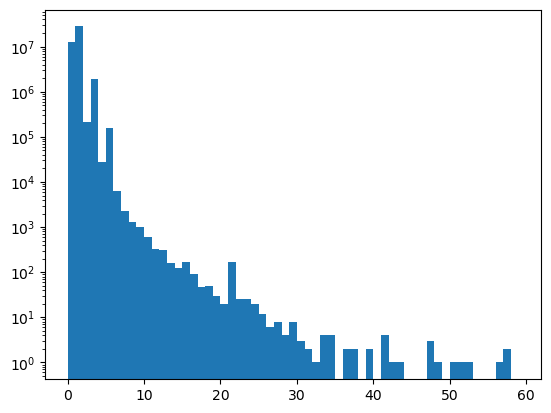

In [16]:
temp3 = np.array(temp.dt/pd.Timedelta(1, 'minutes'))

plt.figure()
plt.hist(temp3,bins=np.arange(60))
plt.yscale('log');

In [53]:
# Delete rows if the timestamp is repeated
temp = segment.time.diff()
temp = temp[temp == pd.Timedelta('0 days 00:00:00')]
segment = segment.drop(labels = temp.index)
    
# Set the time range to prevent extrapolation if there're NaNs in the wind or altitude data
time = np.array(segment.time)
wind_u = np.array(segment.wind_u)
wind_v = np.array(segment.wind_v)
altitude = np.array(segment.altitude)
temp_time = time[np.isnan(wind_u) == 0]
temp_v = wind_v[np.isnan(wind_u) == 0]
temp_alt = altitude[np.isnan(wind_u) == 0]
temp_time = temp_time[np.isnan(temp_v) == 0]
temp_alt = temp_alt[np.isnan(temp_v) == 0]
temp_time = temp_time[np.isnan(temp_alt) == 0]
    
# Create the new time series and the dataframe
new_time = pd.date_range(temp_time[0], temp_time[-1], freq=INTERP_DT)
interpd = pd.DataFrame(columns=['flight_id','time','latitude','longitude','altitude',
                                'pressure','wind_u','wind_v','T_cosmic','dTdz_cosmic',
                                'N_cosmic','altitude_spike','segment_id','segment_id_old'])
interpd.time = new_time
interpd.flight_id = segment.flight_id.iloc[0]
interpd.segment_id = segment.segment_id.iloc[0]
interpd.segment_id_old = segment.segment_id_old.iloc[0]
    
# Times must be converted to a float before fields can be interpolated
#time_float = np.array(segment.time).astype('float')
#new_time_float = np.array(new_time).astype('float')
time_float = np.array((time - time[0])/pd.Timedelta(1, 'minutes'))
new_time_float = np.array((new_time - time[0])/pd.Timedelta(1, 'minutes'))
N_temp = np.size(new_time_float)
# For dealing with the date line:
temp_longitude = np.array(segment.longitude)
temp_longitude[temp_longitude < 0] = temp_longitude[temp_longitude < 0] + 360
    
# There can be NaNs in some fields. Delete these and make new time series for interpolation
T_cosmic = np.array(segment.T_cosmic)
dTdz_cosmic = np.array(segment.dTdz_cosmic)
time_float_alt = time_float[np.isnan(altitude) == 0]
time_float_u = time_float[np.isnan(wind_u) == 0]
time_float_v = time_float[np.isnan(wind_v) == 0]
time_float_T = time_float[np.isnan(T_cosmic) == 0]
time_float_dTdz = time_float[np.isnan(dTdz_cosmic) == 0]
altitude = altitude[np.isnan(altitude) == 0]
wind_u = wind_u[np.isnan(wind_u) == 0]
wind_v = wind_v[np.isnan(wind_v) == 0]
T_cosmic = T_cosmic[np.isnan(T_cosmic) == 0]
dTdz_cosmic = dTdz_cosmic[np.isnan(dTdz_cosmic) == 0]
    
# Do the interpolation
f1 = interpolate.PchipInterpolator(time_float, segment.latitude)
f2 = interpolate.PchipInterpolator(time_float, segment.longitude)
f2b = interpolate.PchipInterpolator(time_float, temp_longitude)
f3 = interpolate.PchipInterpolator(time_float_alt, altitude)
f4 = interpolate.PchipInterpolator(time_float, segment.pressure)
f5 = interpolate.PchipInterpolator(time_float_u, wind_u)
f6 = interpolate.PchipInterpolator(time_float_v, wind_v)
f7 = interpolate.PchipInterpolator(time_float_T, T_cosmic)
f8 = interpolate.PchipInterpolator(time_float_dTdz, dTdz_cosmic)
f9 = interpolate.PchipInterpolator(time_float, segment.N_cosmic)
f10 = interpolate.PchipInterpolator(time_float, segment.altitude_spike)
interpd.latitude = f1(new_time_float)
longitude1 = f2(new_time_float)
longitude2 = f2b(new_time_float)
interpd.altitude = f3(new_time_float)
interpd.pressure = f4(new_time_float)
interpd.wind_u = f5(new_time_float)
interpd.wind_v = f6(new_time_float)
interpd.T_cosmic = f7(new_time_float)
interpd.dTdz_cosmic = f8(new_time_float)
interpd.N_cosmic = f9(new_time_float)
interpd.altitude_spike = f10(new_time_float)
    
## Deal with balloons crossing the date line
# Identify intervals where the balloon crossed the date line
dlon = np.array(segment.longitude)
dlon = np.diff(dlon)
indices = 1 + np.arange(np.size(dlon))
indices_new = np.arange(np.size(new_time_float))
print(np.nanmax(np.abs(dlon)))
if np.nanmax(np.abs(dlon)) < 180:
    print('no date line crossing')
    interpd.longitude = longitude1
else:
    print('date line crossing')
    ind_crossings = indices[np.abs(dlon) > 180]
    n_crossings = np.size(ind_crossings)
    for i in np.arange(n_crossings):
        ind_start = ind_crossings[i] - 1
        ind_stop = ind_crossings[i]
        time_float_start = time_float[ind_start]
        time_float_stop = time_float[ind_stop]
        # Find new_time_float indices in this time range
        temp_time = new_time_float.copy()
        ind_new_crossing = indices_new[temp_time > time_float_start]
        temp_time = temp_time[temp_time > time_float_start]
        ind_new_crossing = ind_new_crossing[temp_time < time_float_stop]
        # Replace longitude1 with longitude2 for those indices
        longitude1[ind_new_crossing] = longitude2[ind_new_crossing]
        print(time_float_start,time_float_stop)
    # Make sure the longitude range is -180 to 180
    longitude1[longitude1 > 180] = longitude1[longitude1 > 180] - 360
    interpd.longitude = longitude1

359.960422
date line crossing
3227.02215 3232.02215


### Interpolate the data onto an evenly spaced time grid

The method is phip interpolation, which smoothes the data without creating overshoots.
(Overshoots were a big problem with normal cubic interpolation.)

In [5]:
def interp_flight(segment):
    
    # Delete rows if the timestamp is repeated
    temp = segment.time.diff()
    temp = temp[temp == pd.Timedelta('0 days 00:00:00')]
    segment = segment.drop(labels = temp.index)
    
    # Set the time range to prevent extrapolation if there're NaNs in the wind or altitude data
    time = np.array(segment.time)
    wind_u = np.array(segment.wind_u)
    wind_v = np.array(segment.wind_v)
    altitude = np.array(segment.altitude)
    temp_time = time[np.isnan(wind_u) == 0]
    temp_v = wind_v[np.isnan(wind_u) == 0]
    temp_alt = altitude[np.isnan(wind_u) == 0]
    temp_time = temp_time[np.isnan(temp_v) == 0]
    temp_alt = temp_alt[np.isnan(temp_v) == 0]
    temp_time = temp_time[np.isnan(temp_alt) == 0]
    
    # Create the new time series and the dataframe
    new_time = pd.date_range(temp_time[0], temp_time[-1], freq=INTERP_DT)
    interpd = pd.DataFrame(columns=['flight_id','time','latitude','longitude','altitude',
                                    'pressure','wind_u','wind_v','T_cosmic','dTdz_cosmic',
                                    'N_cosmic','altitude_spike','segment_id','segment_id_old'])
    interpd.time = new_time
    interpd.flight_id = segment.flight_id.iloc[0]
    interpd.segment_id = segment.segment_id.iloc[0]
    interpd.segment_id_old = segment.segment_id_old.iloc[0]
    
    # Times must be converted to a float before fields can be interpolated
    time_float = np.array((time - time[0])/pd.Timedelta(1, 'minutes'))
    new_time_float = np.array((new_time - time[0])/pd.Timedelta(1, 'minutes'))
    N_temp = np.size(new_time_float)
    # For dealing with the date line:
    temp_longitude = np.array(segment.longitude)
    temp_longitude[temp_longitude < 0] = temp_longitude[temp_longitude < 0] + 360
    
    # There can be NaNs in some fields. Delete these and make new time series for interpolation
    T_cosmic = np.array(segment.T_cosmic)
    dTdz_cosmic = np.array(segment.dTdz_cosmic)
    time_float_alt = time_float[np.isnan(altitude) == 0]
    time_float_u = time_float[np.isnan(wind_u) == 0]
    time_float_v = time_float[np.isnan(wind_v) == 0]
    time_float_T = time_float[np.isnan(T_cosmic) == 0]
    time_float_dTdz = time_float[np.isnan(dTdz_cosmic) == 0]
    altitude = altitude[np.isnan(altitude) == 0]
    wind_u = wind_u[np.isnan(wind_u) == 0]
    wind_v = wind_v[np.isnan(wind_v) == 0]
    T_cosmic = T_cosmic[np.isnan(T_cosmic) == 0]
    dTdz_cosmic = dTdz_cosmic[np.isnan(dTdz_cosmic) == 0]
    
    # Do the interpolation
    f1 = interpolate.PchipInterpolator(time_float, segment.latitude)
    f2 = interpolate.PchipInterpolator(time_float, segment.longitude)
    f2b = interpolate.PchipInterpolator(time_float, temp_longitude)
    f3 = interpolate.PchipInterpolator(time_float_alt, altitude)
    f4 = interpolate.PchipInterpolator(time_float, segment.pressure)
    f5 = interpolate.PchipInterpolator(time_float_u, wind_u)
    f6 = interpolate.PchipInterpolator(time_float_v, wind_v)
    f7 = interpolate.PchipInterpolator(time_float_T, T_cosmic)
    f8 = interpolate.PchipInterpolator(time_float_dTdz, dTdz_cosmic)
    f9 = interpolate.PchipInterpolator(time_float, segment.N_cosmic)
    f10 = interpolate.PchipInterpolator(time_float, segment.altitude_spike)
    interpd.latitude = f1(new_time_float)
    longitude1 = f2(new_time_float)
    longitude2 = f2b(new_time_float)
    interpd.altitude = f3(new_time_float)
    interpd.pressure = f4(new_time_float)
    interpd.wind_u = f5(new_time_float)
    interpd.wind_v = f6(new_time_float)
    interpd.T_cosmic = f7(new_time_float)
    interpd.dTdz_cosmic = f8(new_time_float)
    interpd.N_cosmic = f9(new_time_float)
    interpd.altitude_spike = f10(new_time_float)
    
    ## Deal with balloons crossing the date line
    # Identify intervals where the balloon crossed the date line
    dlon = np.array(segment.longitude)
    dlon = np.diff(dlon)
    indices = 1 + np.arange(np.size(dlon))
    indices_new = np.arange(np.size(new_time_float))
    if np.nanmax(np.abs(dlon)) < 180:
        interpd.longitude = longitude1
    else:
        ind_crossings = indices[np.abs(dlon) > 180]
        n_crossings = np.size(ind_crossings)
        for i in np.arange(n_crossings):
            ind_start = ind_crossings[i] - 1
            ind_stop = ind_crossings[i]
            time_float_start = time_float[ind_start]
            time_float_stop = time_float[ind_stop]
            # Find new_time_float indices in this time range
            temp_time = new_time_float.copy()
            ind_new_crossing = indices_new[temp_time > time_float_start]
            temp_time = temp_time[temp_time > time_float_start]
            ind_new_crossing = ind_new_crossing[temp_time < time_float_stop]
            # Replace longitude1 with longitude2 for those indices
            longitude1[ind_new_crossing] = longitude2[ind_new_crossing]
        # Make sure the longitude range is -180 to 180
        longitude1[longitude1 > 180] = longitude1[longitude1 > 180] - 360
        interpd.longitude = longitude1
    
    return interpd

temp = flights.groupby('segment_id').progress_apply(interp_flight).reset_index(drop=True)

flights = temp.copy()
del temp

  0%|          | 0/124054 [00:00<?, ?it/s]

### Save the data to disk

In [6]:
flights.to_feather('5_flights_interptime_new.feather')

### Save just the segments that are at least two days long

In [7]:
flights = pd.read_feather('5_flights_interptime_new.feather')

# Delete segments that are too short
print('Calculating segment length:')
num_before = flights.segment_id.nunique()
segment_length = flights.groupby('segment_id').progress_apply(lambda f: f.time.iloc[-1] - f.time.iloc[0])
segments_tooshort = segment_length[segment_length < pd.Timedelta(2,'days')]
flights = flights[~flights.segment_id.isin(segments_tooshort.index)].reset_index(drop=True)
print(f'Of the original {num_before} segments, {flights.segment_id.nunique()} are at least two days long')

flights.to_feather('5_flights_interptime_2daysegments_paper.feather')

Calculating segment length:


  0%|          | 0/124054 [00:00<?, ?it/s]

Of the original 124054 segments, 943 are at least two days long
